In [ ]:
import sys
import os
notebook_path = os.path.abspath(os.path.join(os.getcwd(), '../../'))
if notebook_path not in sys.path:
    sys.path.insert(0, notebook_path)

import torch
from torch.utils.data import DataLoader
import argparse
from skimage.metrics import peak_signal_noise_ratio as psnr 
import pandas as pd
sys.path.append('../')
from training.utils import utils
from training.data import dataset
from models import utils as model_utils
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt



c:\Users\ismae\anaconda3\envs\CNC\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.6 when it was built against 1.14.5, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
# load model
model_name = 'WCRR-CNN'
model = utils.load_model(model_name, 'cpu')
model.eval()
print(" **** Updating the Lipschitz constant **** ")
sn_pm = model.conv_layer.spectral_norm(mode="power_method", n_steps=200)

Multi convolutionnal layer:  {'num_channels': [1, 4, 8, 60], 'size_kernels': [5, 5, 5]}
 **** Updating the Lipschitz constant **** 


In [6]:
# load img
img_path = 'img/04.png'
img = np.float32(cv2.imread(img_path)[:, :, 0])
img = torch.from_numpy(img)
img = img[None, None, :, :]/255

In [7]:
# add noise 
sigma = torch.tensor(25).view(-1,1,1,1)
img_noisy = img + sigma/255*torch.empty_like(img).normal_()

# denoise 
with torch.no_grad():
    # img_denoised, _, _ = model_utils.accelerated_gd_single(img_noisy, model, sigma=sigma, ada_restart=True, tol=1e-4)
    # erreur --> variable 'idx' referenced before assignment
    img_denoised, _, _ = model_utils.accelerated_gd_batch(img_noisy, model, sigma=sigma, ada_restart=True, tol=1e-4)
    

psnr_ = psnr(img.numpy(), img_denoised.numpy(), data_range=1)

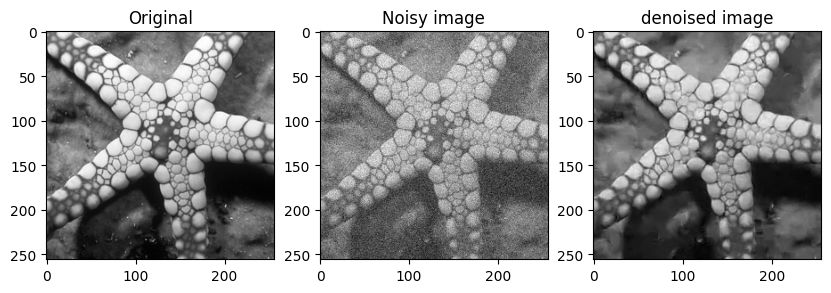

In [8]:
# plot
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize =(10,10))
ax1.imshow(img[0,0, :,:], cmap= "gray")
ax1.set_title('Original')
ax2.imshow(img_noisy[0,0, :,:], cmap= "gray")
ax2.set_title('Noisy image')
ax3.imshow(img_denoised[0,0, :,:], cmap= "gray")
ax3.set_title('denoised image')
plt.show()

In [22]:
psnr_

np.float64(28.063885068366645)